In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm

In [3]:
price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.sort_index(inplace=True)
price_df = price_df.loc['2018-01-01':]
price_df

,open,high,low,close
date,,,,
2018-01-01 00:00:00,13715.65,13715.65,13681.00,13707.92
2018-01-01 00:01:00,13707.91,13707.91,13666.11,13694.92
2018-01-01 00:02:00,13682.00,13694.94,13680.00,13680.00
2018-01-01 00:03:00,13679.98,13679.98,13601.00,13645.99
2018-01-01 00:04:00,13645.98,13646.00,13576.28,13600.00
...,...,...,...,...
2021-09-04 15:56:00,49845.77,49856.55,49821.46,49821.46
2021-09-04 15:57:00,49821.47,49836.10,49800.86,49800.88
2021-09-04 15:58:00,49800.88,49826.93,49793.07,49826.92


In [11]:
price_df.index.dtype

dtype('<M8[ns]')

In [13]:
price_df.asfreq('d').index.dtype

dtype('<M8[ns]')

In [4]:
CAPITAL = 1000

## Buy & Hold BTC

In [5]:
def buy_and_hold_by_ratio(price_df, asset_ratio, capital):
    cash_ratio = 1 - asset_ratio
    
    buy_and_hold_df = price_df.copy()
    
    price = buy_and_hold_df['close'].iloc[0]
    buy_and_hold_df['asset_amount'] = asset_ratio * capital / price
    buy_and_hold_df['asset_value'] = buy_and_hold_df['asset_amount'] * buy_and_hold_df['close']
    buy_and_hold_df['cash'] = cash_ratio * capital
    buy_and_hold_df['nav'] = buy_and_hold_df['asset_value'] + buy_and_hold_df['cash']
    return buy_and_hold_df
buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)

,open,high,low,close,asset_amount,asset_value,cash,nav
date,,,,,,,,
2018-01-01 00:00:00,13715.65,13715.65,13681.00,13707.92,0.036475,500.000000,500.0,1000.000000
2018-01-01 00:01:00,13707.91,13707.91,13666.11,13694.92,0.036475,499.525822,500.0,999.525822
2018-01-01 00:02:00,13682.00,13694.94,13680.00,13680.00,0.036475,498.981611,500.0,998.981611
2018-01-01 00:03:00,13679.98,13679.98,13601.00,13645.99,0.036475,497.741087,500.0,997.741087
2018-01-01 00:04:00,13645.98,13646.00,13576.28,13600.00,0.036475,496.063590,500.0,996.063590
...,...,...,...,...,...,...,...,...
2021-09-04 15:56:00,49845.77,49856.55,49821.46,49821.46,0.036475,1817.250903,500.0,2317.250903
2021-09-04 15:57:00,49821.47,49836.10,49800.86,49800.88,0.036475,1816.500242,500.0,2316.500242
2021-09-04 15:58:00,49800.88,49826.93,49793.07,49826.92,0.036475,1817.450058,500.0,2317.450058


## Time-based Rebalancing

In [6]:
def ohlc_resampler(df):

    if len(df) == 0:
        return pd.Series({
            'open': np.NaN,
            'high': np.NaN,
            'low': np.NaN,
            'close':np.NaN
        })
    return pd.Series({
        'open': df.loc[df.index.min(), 'open'],
        'high': df['high'].max(),
        'low': df['low'].min(),
        'close': df.loc[df.index.max(), 'close']
    })
def resample_ohlc(asset_df, timeframe):
    return asset_df.groupby(pd.Grouper(freq=timeframe)).apply(ohlc_resampler)

In [14]:
def time_rebalance(price_df, asset_ratio, capital, timeframe='1d'):
    
    cash_ratio = 1 - asset_ratio

    price_df = price_df.copy()
#     rebalance_df = pd.DataFrame(index=price_df.index).asfreq(freq=timeframe)
    rebalance_df = resample_ohlc(price_df, timeframe)
    # init
    init_index = rebalance_df.index[0]
    init_asset_value = capital * asset_ratio
    init_asset_amount = init_asset_value / price_df.loc[init_index, 'close']
    init_cash = capital * cash_ratio

    rebalance_df.loc[init_index, 'nav'] = capital
    rebalance_df.loc[init_index, 'asset_value'] = init_asset_value
    rebalance_df.loc[init_index, 'asset_amount'] = init_asset_amount
    rebalance_df.loc[init_index, 'cash'] = capital * cash_ratio


    original_asset_value = init_asset_value
    original_asset_amount = init_asset_amount
    original_cash = init_cash

    for index in rebalance_df.index:

        price = price_df.at[index, 'close']

        # Update asset price / value

        original_asset_value = original_asset_amount * price
        original_nav = original_asset_value + original_cash

        # Calculate rebalancing

        rebalanced_asset_value = original_nav * asset_ratio
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price
        rebalanced_cash = original_cash - diff_asset_value
        rebalanced_asset_amount = original_asset_amount + diff_asset_amount
        rebalanced_nav = rebalanced_asset_value + rebalanced_cash


        action = 'Buy' if diff_asset_value >= 0 else 'Sell'

        # add to dataframe

        rebalance_df.at[index, 'asset_value'] = original_asset_value
        rebalance_df.at[index, 'asset_amount'] = original_asset_amount
        rebalance_df.at[index, 'cash'] = original_cash
        rebalance_df.at[index, 'nav'] = original_nav

        rebalance_df.at[index, 'diff_asset_value'] = diff_asset_value
        rebalance_df.at[index, 'action'] = action

        rebalance_df.at[index, 're_asset_value'] = rebalanced_asset_value
        rebalance_df.at[index, 're_asset_amount'] = rebalanced_asset_amount
        rebalance_df.at[index, 're_cash'] = rebalanced_cash
        rebalance_df.at[index, 're_nav'] = rebalanced_nav


        # Update original value / nav

        original_asset_amount = rebalanced_asset_amount
        original_cash = rebalanced_cash
    # Merge to price_df
    price_df = price_df.merge(rebalance_df, how='left', left_index=True, right_index=True)
    price_df[['asset_amount', 'cash']] = price_df[['asset_amount', 'cash']].ffill()
    price_df['asset_value'] = price_df['asset_amount'] * price_df['close']
    price_df['nav'] = price_df['asset_value'] + price_df['cash']
    
    return price_df, rebalance_df



In [15]:
re_price_df, rebalance_df = time_rebalance(price_df, asset_ratio=0.5, capital=CAPITAL)

KeyError: Timestamp('2018-02-09 00:00:00', freq='D')

In [ ]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                            },
                            index=price_df.index)
for asset_ratio in tqdm.tqdm(np.arange(0.1, 1.0, 0.1)):
    re_price_df, rebalance_df = time_rebalance(price_df, asset_ratio=asset_ratio, capital=CAPITAL, timeframe='1h')
    comparison_df[f'time-based 1h rebalancing {int(asset_ratio*100)} %'] = re_price_df['nav']
for asset_ratio in tqdm.tqdm(np.arange(0.1, 1.0, 0.1)):
    re_price_df, rebalance_df = time_rebalance(price_df, asset_ratio=asset_ratio, capital=CAPITAL, timeframe='1d')
    comparison_df[f'time-based 1d rebalancing {int(asset_ratio*100)} %'] = re_price_df['nav']
comparison_df.plot(figsize=(16, 6), title='NAV')

In [34]:
def expected_return(prices, risk_free_rate):
    return (prices.pct_change() - risk_free_rate).mean() 
def volatility(prices):
    return prices.pct_change().std()
def sharpe_ratio(prices, risk_free_rate):
    return expected_return(prices, risk_free_rate) / volatility(prices)
def max_drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown.min()

In [12]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
})

NameError: name 'comparison_df' is not defined

In [13]:
efficient_frontier_df.style.background_gradient(axis=0,)


NameError: name 'efficient_frontier_df' is not defined

In [14]:
efficient_frontier_df.plot.scatter(x='volatility', y='return')

NameError: name 'efficient_frontier_df' is not defined

In [15]:
rebalance_comparison_df.apply(lambda prices: prices.pct_change()).hist(figsize=(24, 24), bins=100)

NameError: name 'rebalance_comparison_df' is not defined

In [39]:
def generate_price_trigger(price_df, price_rebalance_ratio):
    init_price = price_df['close'].iloc[0]

    trigger_data = []
    current_position_price = init_price
    for dt, price in zip(price_df.index.values, price_df['close'].values):

        while True:
            upper_next_position_price = current_position_price * (1 + price_rebalance_ratio)
            lower_next_position_price = current_position_price * (1 - price_rebalance_ratio)

            if price > upper_next_position_price:
                current_position_price = upper_next_position_price
            elif price < lower_next_position_price:
                current_position_price = lower_next_position_price
            else:
                break

            trigger_data.append({
                'date': dt,
                'price': current_position_price
            })

    trigger_df = pd.DataFrame(trigger_data)
    return trigger_df

price_rebalance_ratio = 0.1
trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
trigger_df

,date,price
0,2018-01-02 19:19:00,15078.712000
1,2018-01-05 17:24:00,16586.583200
2,2018-01-08 09:30:00,14927.924880
3,2018-01-08 14:49:00,13435.132392
4,2018-01-08 16:48:00,14778.645631
...,...,...
248,2021-07-21 16:36:00,32257.457492
249,2021-07-26 00:12:00,35483.203241
250,2021-07-26 01:01:00,39031.523566
251,2021-08-06 16:10:00,42934.675922


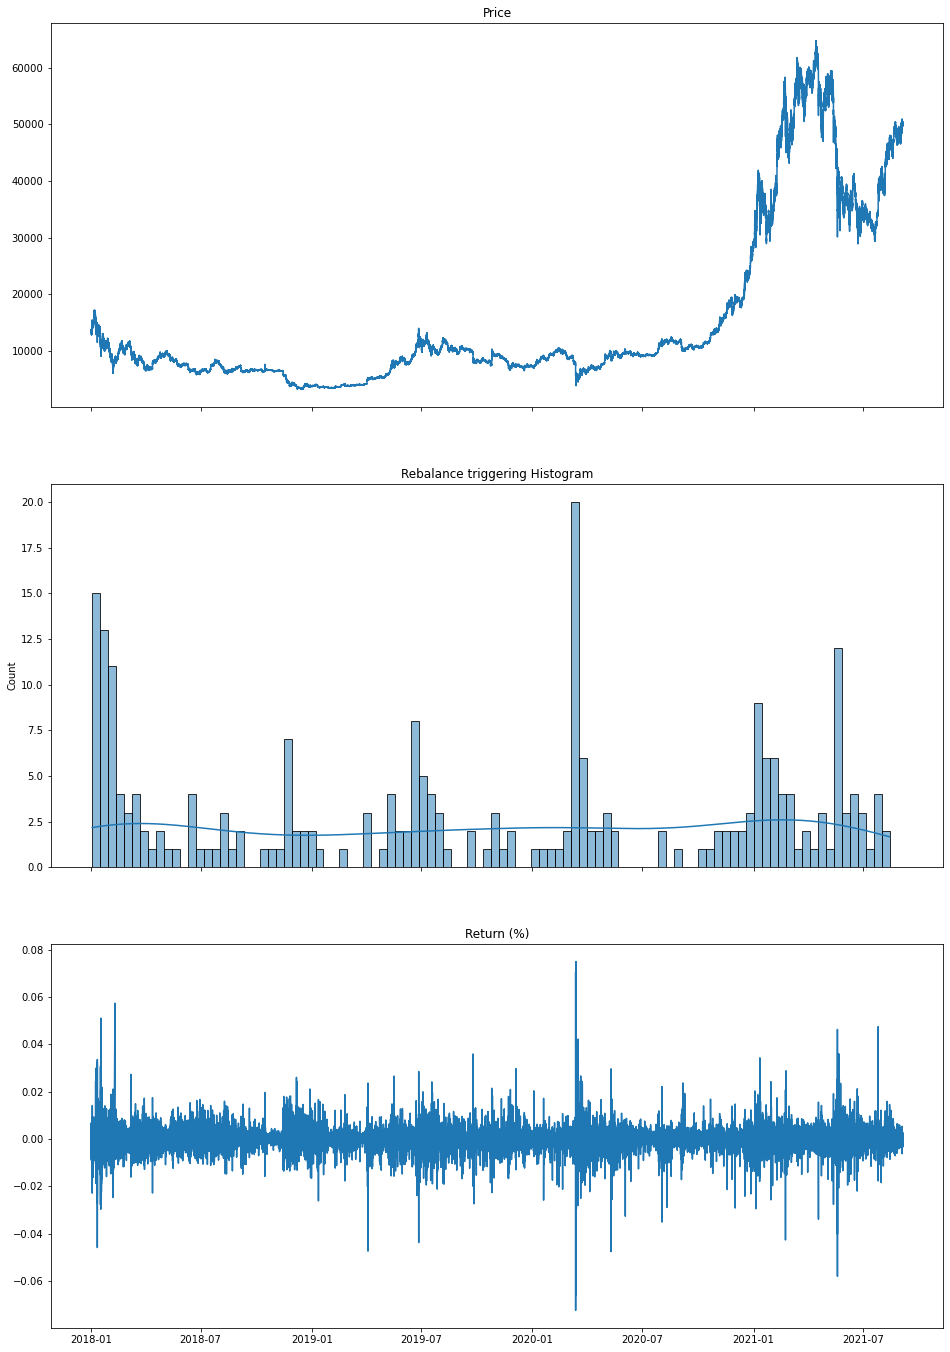

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(16, 24))

ax1.set_title('Price')
ax1.plot(price_df.index, price_df['close'])
ax2.set_title('Rebalance triggering Histogram')
sns.histplot(trigger_df, x='date', bins=100, kde=True, ax=ax2)
ax3.set_title('Return (%)')
ax3.plot(price_df.index, price_df['close'].pct_change())

In [83]:
asset_ratio = 0.5
capital = CAPITAL

def simulate_rebalancing(price_df, trigger_df, asset_ratio, capital):

    cash_ratio = 1 - asset_ratio
    price_df = price_df.copy()
    portfolio_data = []

    # init
    init_index = price_df.index[0]
    init_asset_value = capital * asset_ratio
    init_asset_amount = init_asset_value / price_df.loc[init_index, 'close']
    init_cash = capital * cash_ratio

    # Initial portfolio historical data
    portfolio_data.append({
        'date': init_index,
        'nav': capital,
        'asset_value': init_asset_value,
        'asset_amount': init_asset_amount,
        'cash': capital * cash_ratio
    })

    original_asset_value = init_asset_value
    original_asset_amount = init_asset_amount
    original_cash = init_cash

    for index, dt, price in trigger_df.itertuples():

        
#         # Update asset price / value

#         original_asset_value = original_asset_amount * price
#         original_nav = original_asset_value + original_cash

#         # Calculate rebalancing

#         rebalanced_asset_value = original_nav * asset_ratio
#         diff_asset_value = rebalanced_asset_value - original_asset_value
#         diff_asset_amount = diff_asset_value / price
#         rebalanced_cash = original_cash - diff_asset_value
#         rebalanced_asset_amount = original_asset_amount + diff_asset_amount
#         rebalanced_nav = rebalanced_asset_value + rebalanced_cash

        # Update asset price / value

        original_asset_value = original_asset_amount * price
        original_nav = original_asset_value + original_cash

        # Calculate rebalancing

        rebalanced_asset_value = init_asset_value
        diff_asset_value = rebalanced_asset_value - original_asset_value
        diff_asset_amount = diff_asset_value / price
        rebalanced_cash = original_cash - diff_asset_value
        rebalanced_asset_amount = original_asset_amount + diff_asset_amount
        rebalanced_nav = rebalanced_asset_value + rebalanced_cash

        action = 'Buy' if diff_asset_value >= 0 else 'Sell'

        # add to dataframe

        portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': original_asset_value,
            'asset_amount': original_asset_amount,
            'cash': original_cash,
            'nav': original_nav,

            'diff_asset_value': diff_asset_value,
            'action': action,

            're_asset_value': rebalanced_asset_value,
            're_asset_amount': rebalanced_asset_amount,
            're_cash': rebalanced_cash,
            're_nav': rebalanced_nav,
        })

        # Update original value / nav

        original_asset_amount = rebalanced_asset_amount
        original_cash = rebalanced_cash
    portfolio_df = pd.DataFrame(data=portfolio_data).set_index('date')

    # Merge to price_df
    portfolio_price_df = price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
    portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
    portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
    portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
    portfolio_price_df = portfolio_price_df.groupby('date').last()

    return portfolio_df, portfolio_price_df
def price_rebalance(price_df, price_rebalance_ratio, asset_ratio, capital):
    trigger_df = generate_price_trigger(price_df, price_rebalance_ratio)
    return simulate_rebalancing(price_df, trigger_df, asset_ratio, capital)


In [78]:
portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio=0.2, asset_ratio=0.70, capital=CAPITAL)

In [59]:
portfolio_df

,nav,asset_value,asset_amount,cash,price,diff_asset_value,action,re_asset_value,re_asset_amount,re_cash,re_nav
date,,,,,,,,,,,
2017-08-17 04:00:00,1000.000000,700.000000,0.164262,300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-22 05:45:00,860.000000,560.000000,0.164262,300.000000,3409.184000,42.000000,Buy,602.000000,0.176582,258.000000,860.000000
2017-08-22 18:33:00,980.400000,722.400000,0.176582,258.000000,4091.020800,-36.120000,Sell,686.280000,0.167753,294.120000,980.400000
2017-09-02 01:55:00,1117.656000,823.536000,0.167753,294.120000,4909.224960,-41.176800,Sell,782.359200,0.159365,335.296800,1117.656000
2017-09-05 00:53:00,961.184160,625.887360,0.159365,335.296800,3927.379968,46.941552,Buy,672.828912,0.171317,288.355248,961.184160
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-23 16:38:00,5911.682051,3849.467382,0.122923,2062.214669,31316.161124,288.710054,Buy,4138.177436,0.132142,1773.504615,5911.682051
2021-05-24 11:34:00,6739.317538,4965.812923,0.132142,1773.504615,37579.393349,-248.290646,Sell,4717.522277,0.125535,2021.795261,6739.317538
2021-06-22 12:25:00,5795.813083,3774.017821,0.125535,2021.795261,30063.514679,283.051337,Buy,4057.069158,0.134950,1738.743925,5795.813083


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


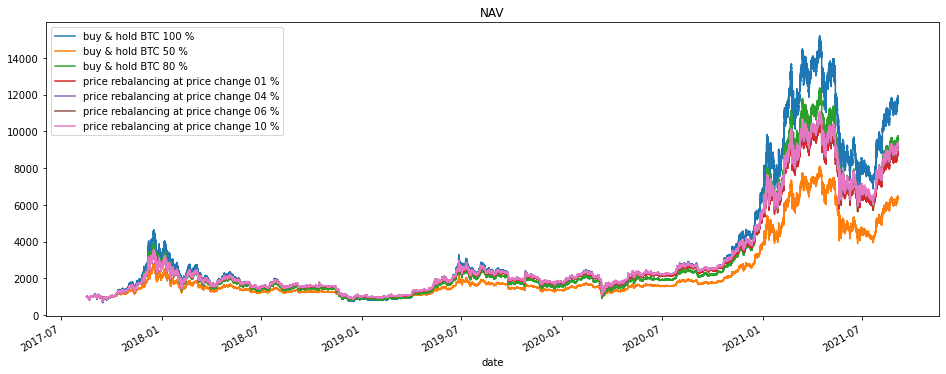

In [64]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_80_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.80, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                                'buy & hold BTC 80 %': buy_and_hold_80_df['nav']
                            },
                            index=price_df.index)

portfolios = {}
for price_rebalance_ratio in tqdm.tqdm(np.arange(0.01, 0.1, 0.03).tolist()):
    portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio, asset_ratio=0.80, capital=CAPITAL)
    portfolio_name = f'price rebalancing at price change {int(price_rebalance_ratio*100):02} %'
    portfolios[portfolio_name] = portfolio_df

    comparison_df[portfolio_name] = portfolio_price_df['nav']
portfolios = pd.Series(portfolios)
comparison_df.plot(figsize=(16, 6), title='NAV')

100%|██████████| 4/4 [00:13<00:00,  3.29s/it]


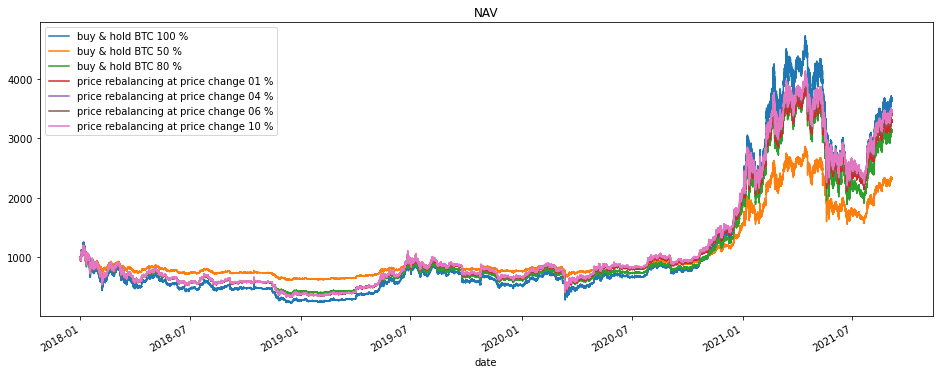

In [71]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_80_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.80, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                                'buy & hold BTC 80 %': buy_and_hold_80_df['nav']
                            },
                            index=price_df.index)

portfolios = {}
for price_rebalance_ratio in tqdm.tqdm(np.arange(0.01, 0.1, 0.03).tolist()):
    portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio, asset_ratio=0.80, capital=CAPITAL)
    portfolio_name = f'price rebalancing at price change {int(price_rebalance_ratio*100):02} %'
    portfolios[portfolio_name] = portfolio_df

    comparison_df[portfolio_name] = portfolio_price_df['nav']
portfolios = pd.Series(portfolios)
comparison_df.plot(figsize=(16, 6), title='NAV')

100%|██████████| 4/4 [00:13<00:00,  3.45s/it]


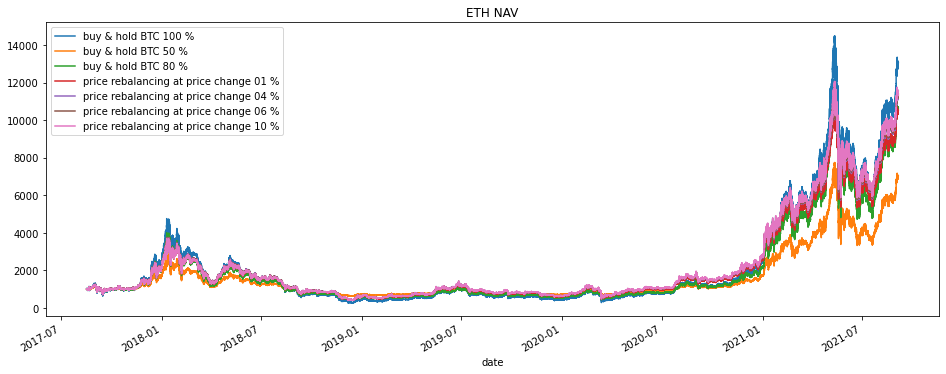

In [79]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_80_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.80, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                                'buy & hold BTC 80 %': buy_and_hold_80_df['nav']
                            },
                            index=price_df.index)

portfolios = {}
for price_rebalance_ratio in tqdm.tqdm(np.arange(0.01, 0.1, 0.03).tolist()):
    portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio, asset_ratio=0.80, capital=CAPITAL)
    portfolio_name = f'price rebalancing at price change {int(price_rebalance_ratio*100):02} %'
    portfolios[portfolio_name] = portfolio_df

    comparison_df[portfolio_name] = portfolio_price_df['nav']
portfolios = pd.Series(portfolios)
comparison_df.plot(figsize=(16, 6), title='ETH NAV')

100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


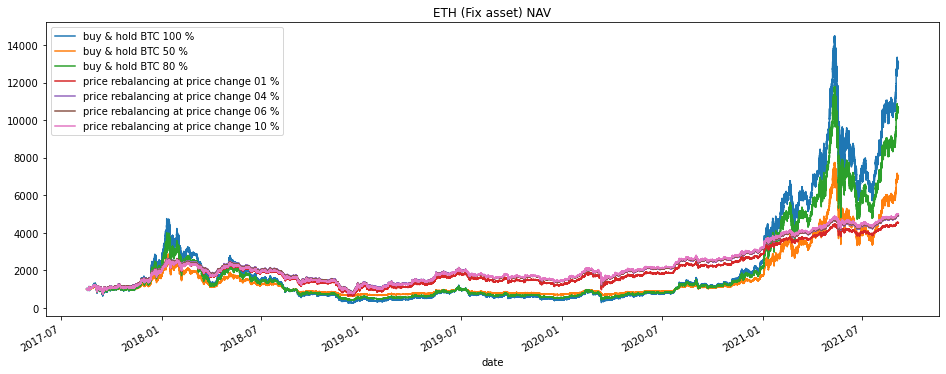

In [84]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_80_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.80, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                                'buy & hold BTC 80 %': buy_and_hold_80_df['nav']
                            },
                            index=price_df.index)

portfolios = {}
for price_rebalance_ratio in tqdm.tqdm(np.arange(0.01, 0.1, 0.03).tolist()):
    portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio, asset_ratio=0.80, capital=CAPITAL)
    portfolio_name = f'price rebalancing at price change {int(price_rebalance_ratio*100):02} %'
    portfolios[portfolio_name] = portfolio_df

    comparison_df[portfolio_name] = portfolio_price_df['nav']
portfolios = pd.Series(portfolios)
comparison_df.plot(figsize=(16, 6), title='ETH (Fix asset) NAV')

100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


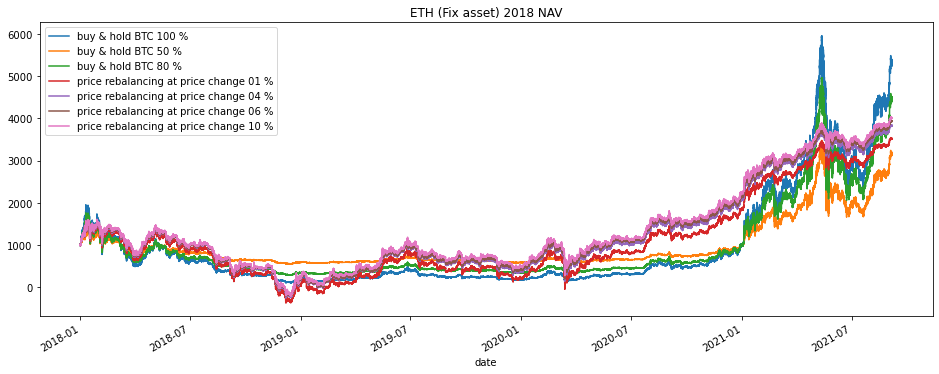

In [89]:
buy_and_hold_50_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.5, capital=CAPITAL)
buy_and_hold_80_df = buy_and_hold_by_ratio(price_df, asset_ratio=0.80, capital=CAPITAL)
buy_and_hold_100_df = buy_and_hold_by_ratio(price_df, asset_ratio=1, capital=CAPITAL)
comparison_df = pd.DataFrame(data={
                                'buy & hold BTC 100 %': buy_and_hold_100_df['nav'],
                                'buy & hold BTC 50 %': buy_and_hold_50_df['nav'],
                                'buy & hold BTC 80 %': buy_and_hold_80_df['nav']
                            },
                            index=price_df.index)

portfolios = {}
for price_rebalance_ratio in tqdm.tqdm(np.arange(0.01, 0.1, 0.03).tolist()):
    portfolio_df, portfolio_price_df = price_rebalance(price_df, price_rebalance_ratio, asset_ratio=0.80, capital=CAPITAL)
    portfolio_name = f'price rebalancing at price change {int(price_rebalance_ratio*100):02} %'
    portfolios[portfolio_name] = portfolio_df

    comparison_df[portfolio_name] = portfolio_price_df['nav']
portfolios = pd.Series(portfolios)
comparison_df.plot(figsize=(16, 6), title='ETH (Fix asset) 2018 NAV')

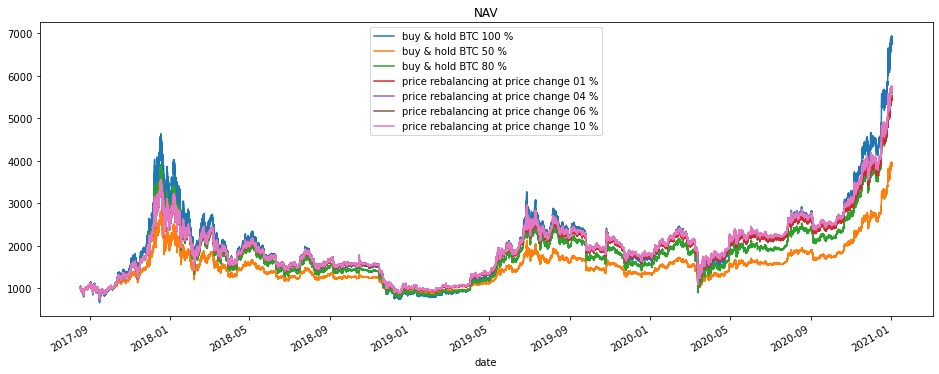

In [65]:
comparison_df.loc[:'2021-01-01'].plot(figsize=(16, 6), title='NAV')

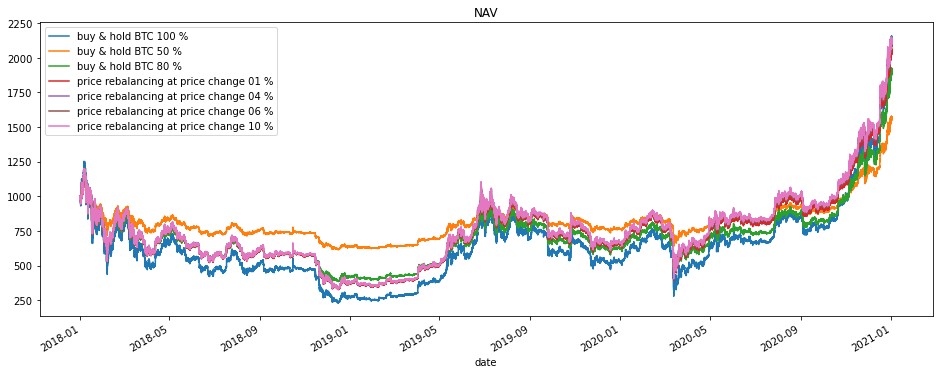

In [72]:
comparison_df.loc[:'2021-01-01'].plot(figsize=(16, 6), title='NAV')

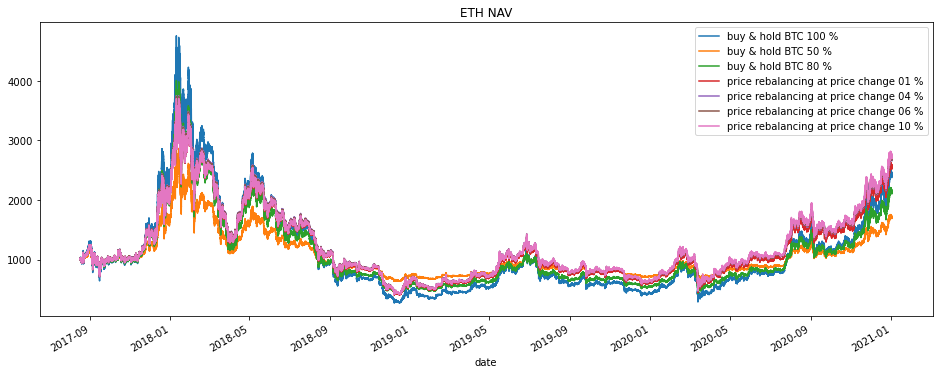

In [80]:
comparison_df.loc[:'2021-01-01'].plot(figsize=(16, 6), title='ETH NAV')

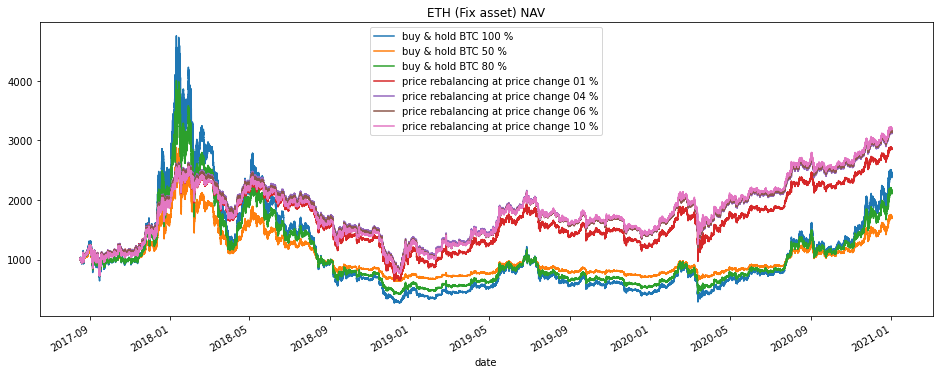

In [85]:
comparison_df.loc[:'2021-01-01'].plot(figsize=(16, 6), title='ETH (Fix asset) NAV')

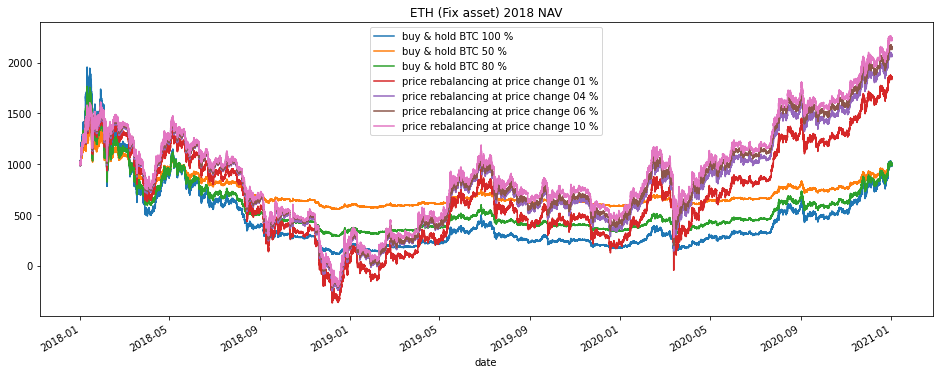

In [91]:
comparison_df.loc[:'2021-01-01'].plot(figsize=(16, 6), title='ETH (Fix asset) 2018 NAV')

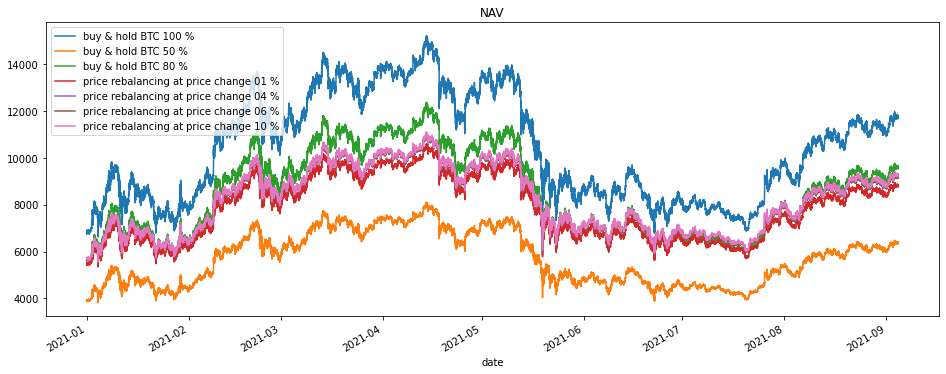

In [66]:
comparison_df.loc['2021-01-01':].plot(figsize=(16, 6), title='NAV')

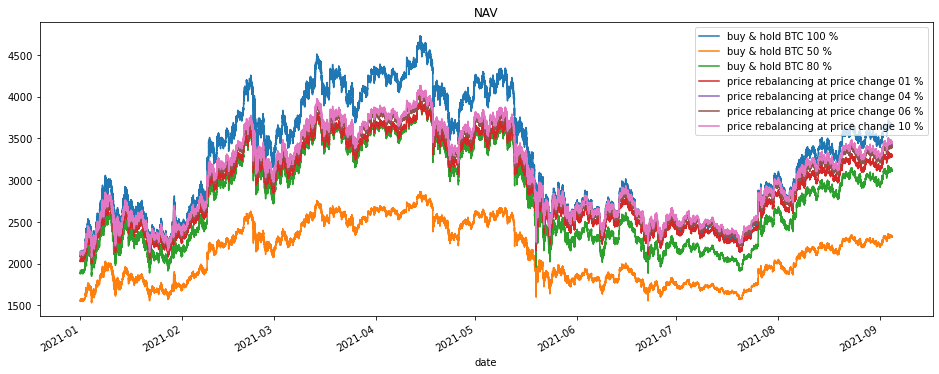

In [73]:
comparison_df.loc['2021-01-01':].plot(figsize=(16, 6), title='NAV')

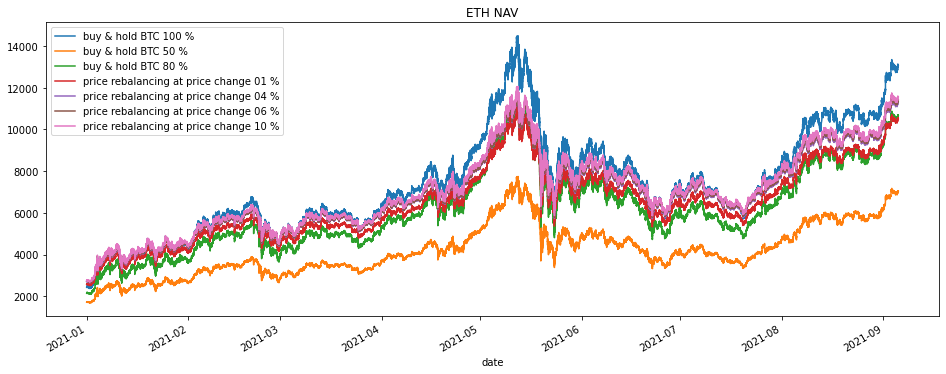

In [81]:
comparison_df.loc['2021-01-01':].plot(figsize=(16, 6), title='ETH NAV')

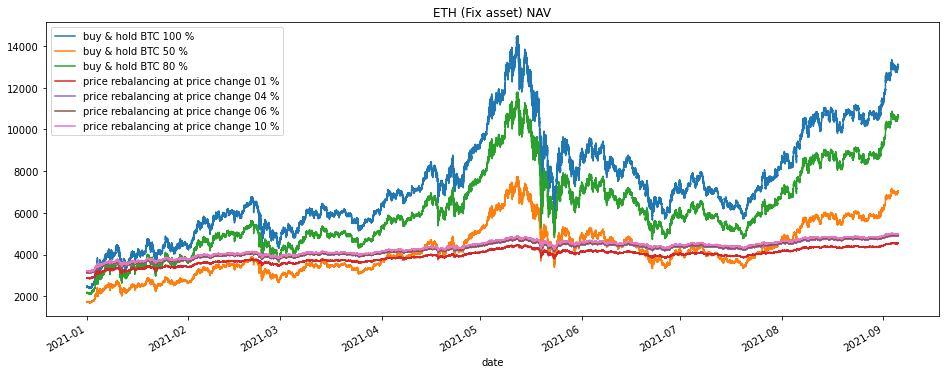

In [86]:
comparison_df.loc['2021-01-01':].plot(figsize=(16, 6), title='ETH (Fix asset) NAV')

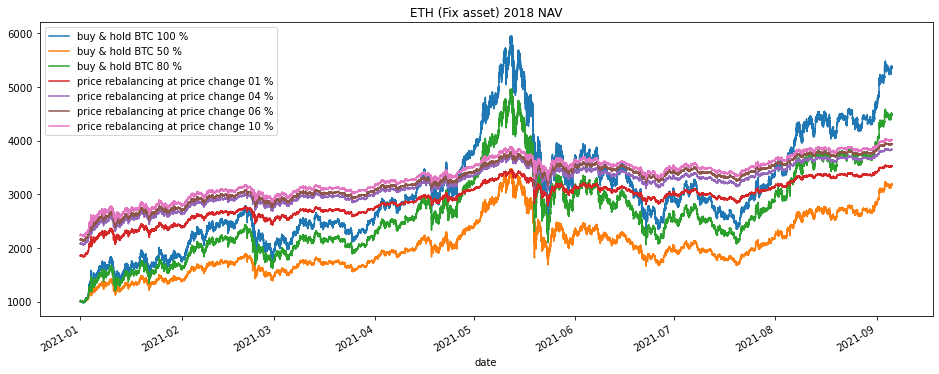

In [92]:
comparison_df.loc['2021-01-01':].plot(figsize=(16, 6), title='ETH (Fix asset) 2018 NAV')

In [67]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': portfolios.map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


,number of order,return,volatility,sharpe,max_drawdown
buy & hold BTC 100 %,0.000000,0.002585,0.042580,0.060713,-0.831822
buy & hold BTC 50 %,0.000000,0.001712,0.030276,0.056538,-0.680182
buy & hold BTC 80 %,0.000000,0.002267,0.038210,0.059319,-0.787908
price rebalancing at price change 01 %,25664.000000,0.002060,0.034099,0.060398,-0.743258
price rebalancing at price change 04 %,1941.000000,0.002088,0.034095,0.061243,-0.738818
price rebalancing at price change 06 %,632.000000,0.002089,0.034152,0.061172,-0.739247
price rebalancing at price change 10 %,321.000000,0.002096,0.034183,0.061326,-0.740178


In [74]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': portfolios.map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


,number of order,return,volatility,sharpe,max_drawdown
buy & hold BTC 100 %,0.000000,0.001808,0.040682,0.044440,-0.811671
buy & hold BTC 50 %,0.000000,0.000830,0.020116,0.041247,-0.450166
buy & hold BTC 80 %,0.000000,0.001329,0.030911,0.042991,-0.675963
price rebalancing at price change 01 %,19424.000000,0.001427,0.032609,0.043770,-0.723040
price rebalancing at price change 04 %,1505.000000,0.001454,0.032601,0.044612,-0.719651
price rebalancing at price change 06 %,480.000000,0.001453,0.032660,0.044481,-0.719984
price rebalancing at price change 10 %,254.000000,0.001464,0.032658,0.044836,-0.719022


In [82]:
# rebalance_comparison_df = comparison_df.filter(regex='.*rebalancing.*')
rebalance_comparison_df = comparison_df.resample('1d').first()
efficient_frontier_df = pd.DataFrame(data={
    'number of order': portfolios.map(len),
    'return': rebalance_comparison_df.apply(expected_return, risk_free_rate=0.00),
    'volatility': rebalance_comparison_df.apply(volatility),
    'sharpe': rebalance_comparison_df.apply(sharpe_ratio, risk_free_rate=0.00),
    'max_drawdown': rebalance_comparison_df.apply(max_drawdown),
}).fillna({'number of order': 0})
efficient_frontier_df.style.background_gradient(axis=0,)


,number of order,return,volatility,sharpe,max_drawdown
buy & hold BTC 100 %,0.000000,0.003202,0.053715,0.059617,-0.939615
buy & hold BTC 50 %,0.000000,0.001851,0.032746,0.056511,-0.771935
buy & hold BTC 80 %,0.000000,0.002587,0.044350,0.058342,-0.891217
price rebalancing at price change 01 %,37212.000000,0.002528,0.043048,0.058722,-0.886505
price rebalancing at price change 04 %,2899.000000,0.002576,0.043038,0.059861,-0.883892
price rebalancing at price change 06 %,967.000000,0.002582,0.043061,0.059966,-0.883824
price rebalancing at price change 10 %,489.000000,0.002591,0.043098,0.060120,-0.883402
